# Cohort Analysis with Python

In [2]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Summary


We are given an [online retail](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II) dataset containing transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.  
  
We are tasked to determine cohorts based on user retention and to provide insights and recommendations to improve customer loyalty.  

Our data contains the following columns:

1. **InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'C', it indicates a cancellation.
2. **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
3. **Description**: Product (item) name. Nominal.
4. **Quantity**: The quantities of each product (item) per transaction. Numeric.
5. **InvoiceDate**: Invoice date and time. Numeric. The day and time when a transaction was generated.
6. **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).
7. **CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
8. **Country**: Country name. Nominal. The name of the country where a customer resides.

# 1. Load and clean the online retail dataset.

In [3]:
# We set Invoice and Customer ID as string types since they are the keys/ID for our dataset.
df = pd.read_csv(r"C:\Users\User\Documents\DATA ANALYST\SELF STUDY\MODULE 5\HA\HA 5.7.5\online_retail.csv",
                   dtype={'Invoice':str, 'Customer ID':str},
                   parse_dates=['InvoiceDate'])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [4]:
# we are only interested in customers who first purchased on December 2009
# get list of customers first
customers = df.loc[df.InvoiceDate < datetime.datetime(2010,1,1), 'Customer ID'].unique()

In [5]:
# filter the transactions
df = df[df['Customer ID'].isin(customers)]

In [6]:
# remove cancellations (Invoices Starts with C)
df = df[~df['Invoice'].str.startswith('C')]

In [7]:
# remove null customer IDs
df = df.dropna(subset=['Customer ID'])

In [8]:
# Add new columns to extract the year and the month
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

In [9]:
df_monthly = df.groupby(['Year', 'Month'])['Invoice'].nunique()

# Creating cohorts using customers with first purchase on December 2009. Grouping them by transaction count and generating a retention matrix.

In [10]:
# remove duplicates
df_cohorts = df[['Customer ID', 'Invoice', 'InvoiceDate']].drop_duplicates()
df_cohorts.head()

,Customer ID,Invoice,InvoiceDate
0,13085,489434,2009-12-01 07:45:00
8,13085,489435,2009-12-01 07:46:00
12,13078,489436,2009-12-01 09:06:00
31,15362,489437,2009-12-01 09:08:00
54,18102,489438,2009-12-01 09:24:00


In [11]:
# all first transaction month is December 2009
df_cohorts['first_txn'] = datetime.datetime(2009, 12, 1)
# convert to year-month
df_cohorts['first_txn'] = df_cohorts['first_txn'].dt.to_period('M')
df_cohorts.head()

,Customer ID,Invoice,InvoiceDate,first_txn
0,13085,489434,2009-12-01 07:45:00,2009-12
8,13085,489435,2009-12-01 07:46:00,2009-12
12,13078,489436,2009-12-01 09:06:00,2009-12
31,15362,489437,2009-12-01 09:08:00,2009-12
54,18102,489438,2009-12-01 09:24:00,2009-12


In [12]:
# Add column for transaction count
# group by Customer ID and rank by ascending InvoiceDate
df_cohorts['txn_count'] = df_cohorts.groupby('Customer ID')['InvoiceDate'].rank(method='first')
df_cohorts.head()

,Customer ID,Invoice,InvoiceDate,first_txn,txn_count
0,13085,489434,2009-12-01 07:45:00,2009-12,1.0
8,13085,489435,2009-12-01 07:46:00,2009-12,2.0
12,13078,489436,2009-12-01 09:06:00,2009-12,1.0
31,15362,489437,2009-12-01 09:08:00,2009-12,1.0
54,18102,489438,2009-12-01 09:24:00,2009-12,1.0


In [13]:
df_cohorts['txn_month'] = df_cohorts['InvoiceDate'].dt.to_period('M')
df_cohorts.head()

,Customer ID,Invoice,InvoiceDate,first_txn,txn_count,txn_month
0,13085,489434,2009-12-01 07:45:00,2009-12,1.0,2009-12
8,13085,489435,2009-12-01 07:46:00,2009-12,2.0,2009-12
12,13078,489436,2009-12-01 09:06:00,2009-12,1.0,2009-12
31,15362,489437,2009-12-01 09:08:00,2009-12,1.0,2009-12
54,18102,489438,2009-12-01 09:24:00,2009-12,1.0,2009-12


In [14]:
# Group by transaction count, transaction month, first transaction date
df_cohorts = df_cohorts.groupby(['txn_count', 'txn_month', 'first_txn'])['Customer ID'].nunique()
df_cohorts.name = 'num_customers'
df_cohorts = df_cohorts.reset_index()
df_cohorts

,txn_count,txn_month,first_txn,num_customers
0,1.0,2009-12,2009-12,955
1,1.0,2010-01,2009-12,18
2,1.0,2010-02,2009-12,15
3,1.0,2010-03,2009-12,14
4,1.0,2010-04,2009-12,9
...,...,...,...,...
1056,202.0,2010-12,2009-12,1
1057,203.0,2010-12,2009-12,1
1058,204.0,2010-12,2009-12,1
1059,205.0,2010-12,2009-12,1


In [15]:
# subtract first_txn from txn_month, this will result in a MonthEnd pandas datatype
# to get the value as integer, we use the pandas apply function
df_cohorts['period_number'] = (df_cohorts.txn_month - df_cohorts.first_txn).apply(lambda x: x.n)


In [16]:
df_pivot = df_cohorts.pivot_table(index='txn_count', columns='period_number', values='num_customers')
df_pivot.head()


period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
txn_count,,,,,,,,,,,,,
1.0,955.0,18.0,15.0,14.0,9.0,2.0,6.0,2.0,1.0,1.0,2.0,2.0,NaN
2.0,286.0,190.0,91.0,109.0,53.0,48.0,36.0,17.0,16.0,16.0,26.0,24.0,NaN
3.0,114.0,100.0,117.0,100.0,94.0,56.0,44.0,31.0,24.0,33.0,37.0,38.0,11.0
4.0,52.0,63.0,77.0,101.0,67.0,57.0,57.0,46.0,30.0,34.0,52.0,43.0,8.0
5.0,30.0,39.0,56.0,56.0,67.0,65.0,59.0,45.0,33.0,35.0,39.0,60.0,14.0


In [17]:
# get the original cohort size - based on how many customers have a given txn_count
df_orig_cohorts = df_pivot.sum(axis=1)
df_orig_cohorts

txn_count
1.0      1027.0
2.0       912.0
3.0       799.0
4.0       687.0
5.0       598.0
          ...  
202.0       1.0
203.0       1.0
204.0       1.0
205.0       1.0
206.0       1.0
Length: 206, dtype: float64

In [18]:
# divide by original cohort size
df_pivot = df_pivot.divide(df_orig_cohorts, axis=0)
df_pivot.head()

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
txn_count,,,,,,,,,,,,,
1.0,0.929893,0.017527,0.014606,0.013632,0.008763,0.001947,0.005842,0.001947,0.000974,0.000974,0.001947,0.001947,NaN
2.0,0.313596,0.208333,0.099781,0.119518,0.058114,0.052632,0.039474,0.018640,0.017544,0.017544,0.028509,0.026316,NaN
3.0,0.142678,0.125156,0.146433,0.125156,0.117647,0.070088,0.055069,0.038798,0.030038,0.041302,0.046308,0.047559,0.013767
4.0,0.075691,0.091703,0.112082,0.147016,0.097525,0.082969,0.082969,0.066958,0.043668,0.049491,0.075691,0.062591,0.011645
5.0,0.050167,0.065217,0.093645,0.093645,0.112040,0.108696,0.098662,0.075251,0.055184,0.058528,0.065217,0.100334,0.023411


In [19]:
import matplotlib
import numpy as np

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
   
    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for _, spine in ax.spines.items():
      spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
   
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# 3. Matrix Presented As Line Charts.

The cohorts on the transaction counts are presented below. The first group of line charts presents cohorts for transaction count 1 to 20. The next group shows the cohorts for transaction count 20 to 40.

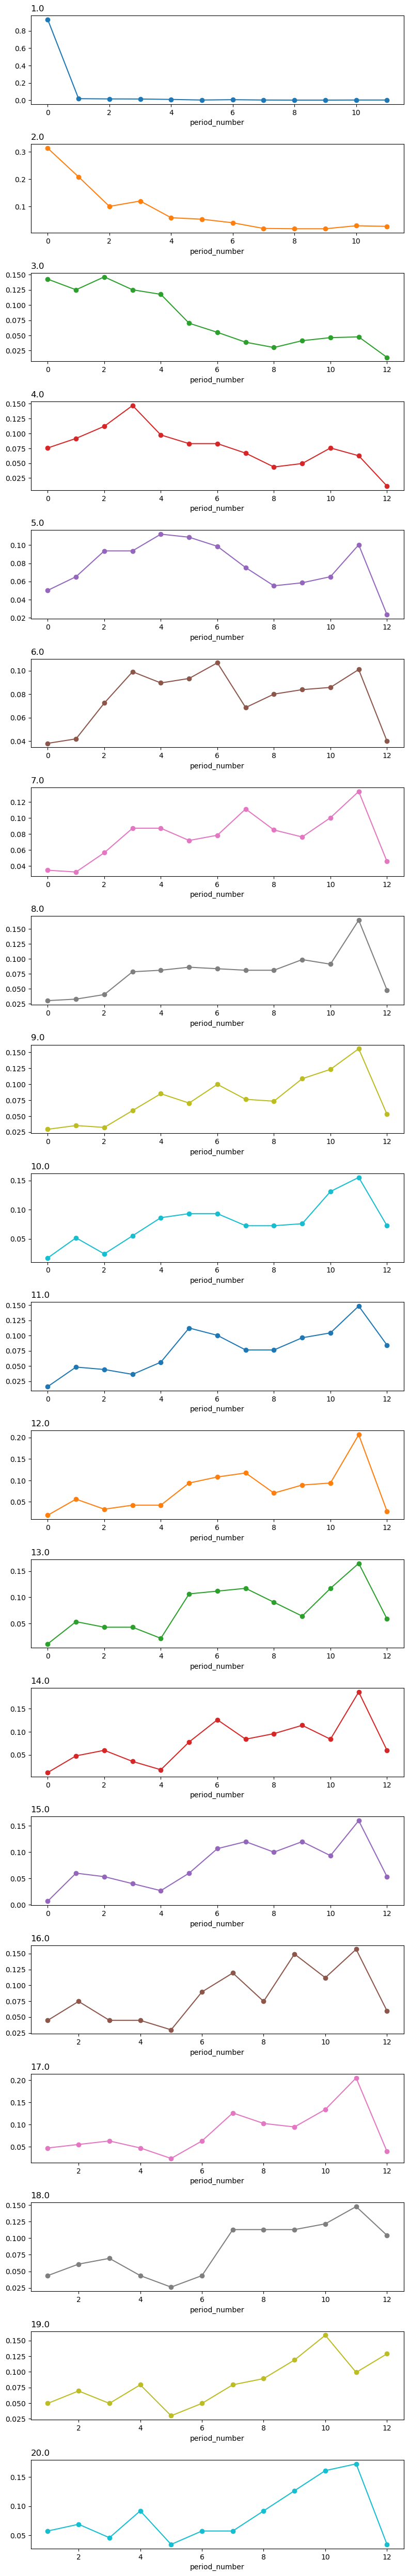

In [20]:
df_rows = df_pivot.iloc[0:20]

fig, ax = plt.subplots(20,1, figsize=(8, 50), sharex=False)

df_rows.T.plot(ax=ax, subplots=True, legend=False, marker='o');

for i, txn_count in enumerate(df_rows.index):
    ax[i].set_title(txn_count, loc='left')

fig.tight_layout(pad=1.0)

plt.show()


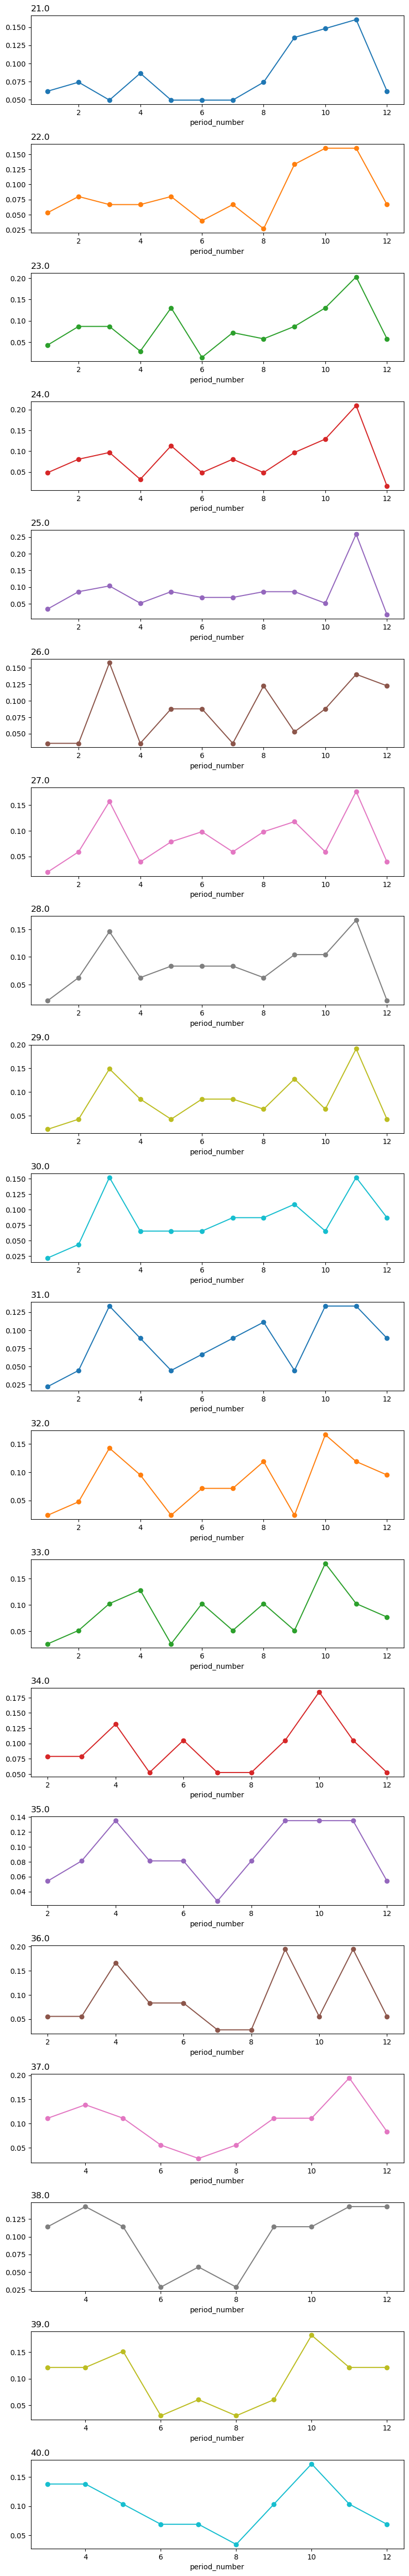

In [21]:
df_rows = df_pivot.iloc[20:40]

fig, ax = plt.subplots(20,1, figsize=(8, 50), sharex=False)

df_rows.T.plot(ax=ax, subplots=True, legend=False, marker='o');

for i, txn_count in enumerate(df_rows.index):
    ax[i].set_title(txn_count, loc='left')

fig.tight_layout(pad=1.0)

plt.show()

# 3. Matrix Presented As Heatmap.

The cohorts on the transaction counts are presented below. The first heatmap  presents cohorts for transaction count 1 to 20. The next heatmap shows the cohorts for transaction count 20 to 40.

Text(0.5, 0, 'Period')

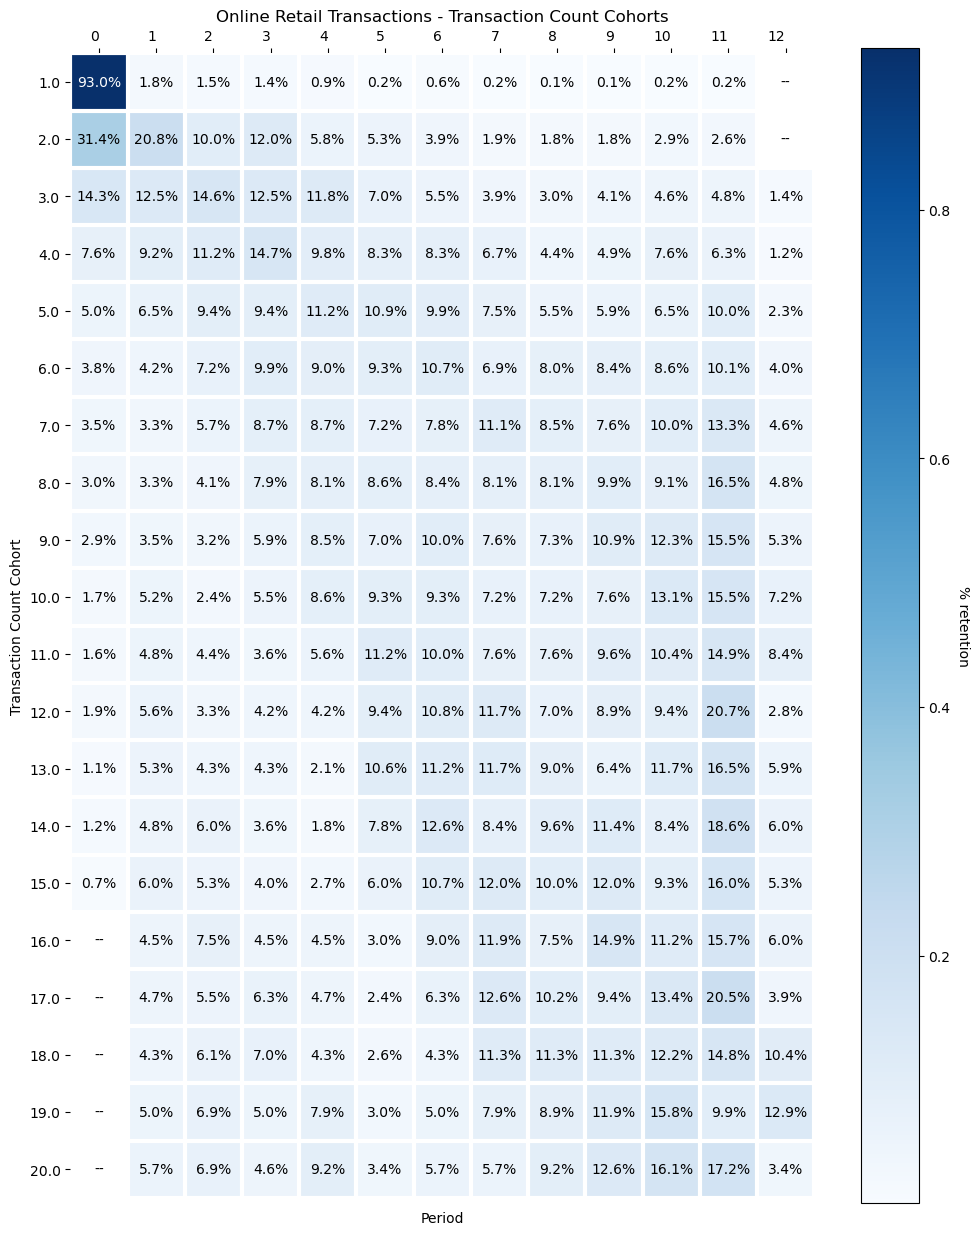

In [23]:
f_20rows = df_pivot.iloc[0:20]

fig, ax = plt.subplots(figsize=(12,15))

im, cbar = heatmap(f_20rows.values, f_20rows.index, f_20rows.columns, ax=ax,
                   cmap="Blues", cbarlabel="% retention")
texts = annotate_heatmap(im, valfmt="{x:.1%}")

ax.set_title('Online Retail Transactions - Transaction Count Cohorts')
ax.set_ylabel('Transaction Count Cohort')
ax.set_xlabel('Period')

Text(0.5, 0, 'Period')

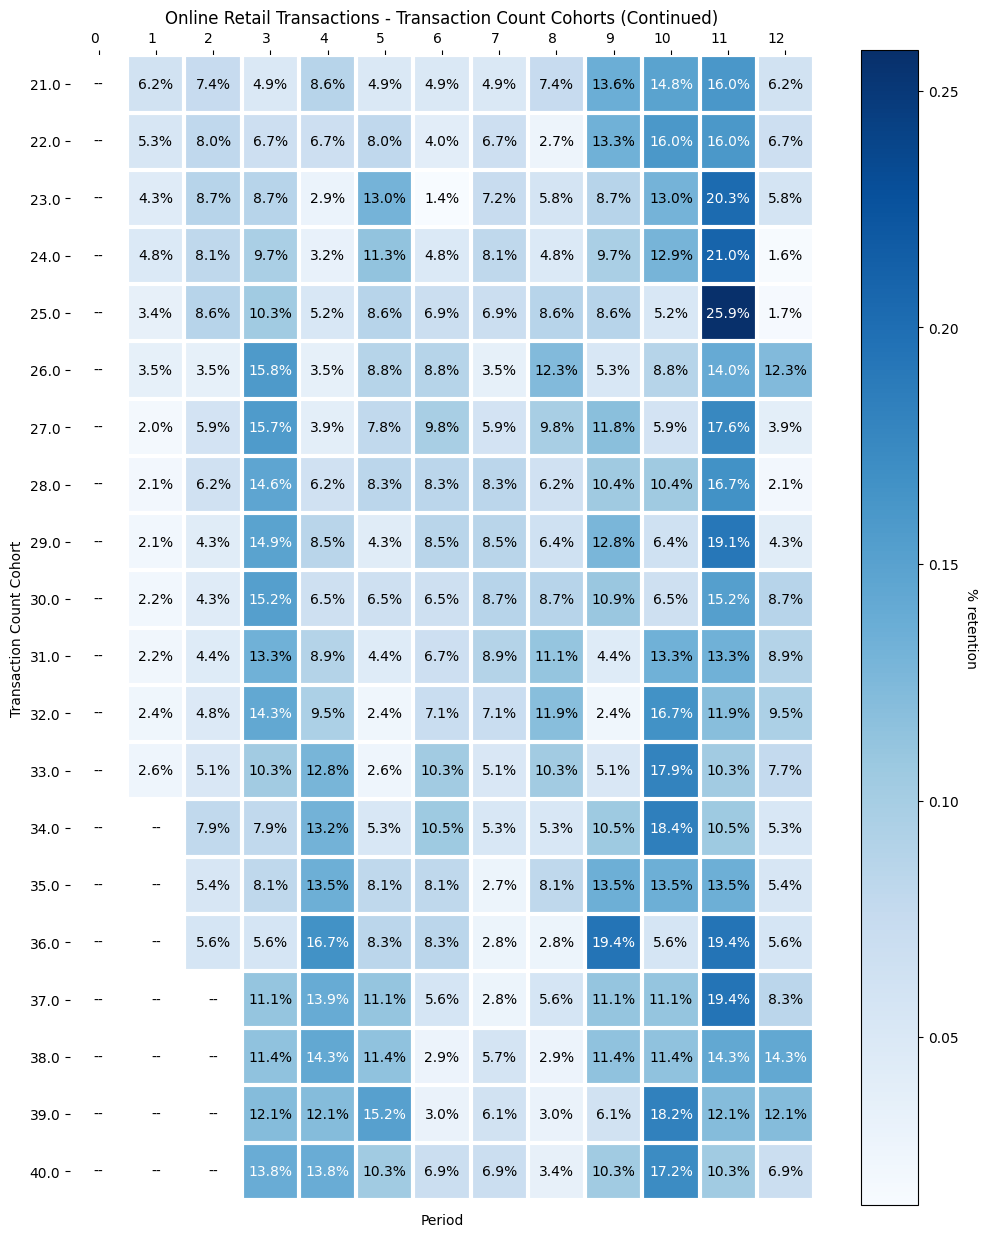

In [26]:
f_20rows = df_pivot.iloc[20:40]

fig, ax = plt.subplots(figsize=(12,15))

im, cbar = heatmap(f_20rows.values, f_20rows.index, f_20rows.columns, ax=ax,
                   cmap="Blues", cbarlabel="% retention")
texts = annotate_heatmap(im, valfmt="{x:.1%}")

ax.set_title('Online Retail Transactions - Transaction Count Cohorts (Continued)')
ax.set_ylabel('Transaction Count Cohort')
ax.set_xlabel('Period')

## Conclusion and Recommendation

We were able to obtain a matrix and visualization that demonstrates the activity of customers who made their first purchase on December 2009. The line charts and heatmap demonstrates that these customers had a high activity or in other words made succeeding transactions within 3 to 4 months of December 2009 and as the number of transactions of the customer increases, higher activity can be seen towards the end of the year at around 10 to 12 months.

This indicates that the Summer Months and Christmas Season are the times during the year where the customer are actively purchasing in the store and then during the middle portion of the year, the customers are not as active. Strategies can be put into place to help retain customers during the middle of the year and the store can capitalize on the activity of customers during Summer and Christmas time.